In [1]:
import sys,os

import numpy as np
from scipy.stats import hypergeom
from fisher import pvalue
import pandas as pd
 
import networkx as nx

import itertools
import warnings
import time, datetime
import copy
import random
import argparse
import pickle
import math

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
min_n_samples = -1
p_val = 0.01
q = 0.5
direction = "UP"
out_dir = os.getcwd()+"/"
basename = "tmp"
seed = 42
alpha = 1.0
beta_K = 1.0
max_n_steps= 200
n_steps_averaged = 20
n_steps_for_convergence = 5

force = False # overwrite temporary files?
verbose = True
report_merging = False
plot_all = True

random.seed(seed)

exprs_file = "simulated_datasets/exprs/simulated.N=10.Mu=2.0.GxP=100,100.overlap=TT.exprs.tsv"
network_file = "simulated_datasets/networks/simulated.N=10.Mu=2.0.GxP=100,100.overlap=TT.tab"
#network_file = "/home/olya/SFU/Breast_cancer/DESMOND/BioGrid_human.tab"
#exprs_file = "../Expression/Harmonized_final/TCGA_micro_nolog2.z.13K_common.tsv"

In [3]:
start_time = time.time()

if basename:
    basename = basename
else: 
    [date_h,mins] = str(datetime.datetime.today()).split(":")[:2]
    [date, hs] = date_h.split()
    basename = "results_"+hs+":"+mins+"_"+date 
    
suffix  = ".alpha="+str(alpha)+",beta_K="+str(beta_K)+",direction="+direction+",p_val="+str(p_val)+",q="+str(q)
if verbose:
    print("Will save output files to:",out_dir + basename + suffix, file = sys.stdout)

Will save output files to: /home/olya/SFU/Breast_cancer/DESMOND_py3/tmp.alpha=1.0,beta_K=1.0,direction=UP,p_val=0.01,q=0.5


In [4]:
from method import prepare_input_data

In [5]:
# read inputs
exprs, network = prepare_input_data(exprs_file, network_file, verbose = verbose, min_n_nodes = 3)

Input:
 	expressions: 2000 genes x 200 samples; 
	network: 2000 genes, 14863 edges in 1 connected components:
Processed Input:
 	expressions: 2000 genes x 200 samples; 
	network: 2000 genes  14863 edges in 1 connected components:
time:	Inputs read in 0.15 s.


In [6]:
# define minimal number of patients in a module
if min_n_samples == -1:
    min_n_samples = int(max(10,0.05*exprs.shape[1])) # set to max(10, 5% of the cohort) 
if verbose:
    print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)

Mininal number of samples in a module: 10


# 1) Assign patients to edges

In [7]:
from partial_RRHO import relabel_exprs_and_network, define_SNR_threshold

In [8]:
# change gene and sample names to ints
exprs,network,ints2g_names,ints2s_names = relabel_exprs_and_network(exprs,network)
exprs_np = exprs.values
exprs_sums = exprs_np.sum(axis=1)
exprs_sq_sums = np.square(exprs_np).sum(axis=1)
N = exprs.shape[1]
exprs_data = N, exprs_sums, exprs_sq_sums

In [9]:
# read min_SNR from file or determine it from avg.SNR distributions among 1000 random edges
snr_file = out_dir+basename +",q="+str(q) +".SNR_threshold.txt"
if not force and os.path.exists(snr_file) and os.path.getsize(snr_file) > 0:
    f = open(snr_file,"r")
    min_SNR = f.readlines()[0]
    f.close()
    try:
        min_SNR = float(min_SNR)
        if verbose:
            print("Using pre-computed SNR threshold:\t%s (q=%s)"%(min_SNR,q),file=sys.stdout)
    except:
        min_SNR = define_SNR_threshold(exprs_np, exprs_data,network,q,snr_file,
                                   min_n_samples=min_n_samples,verbose=verbose)
else:
    min_SNR = define_SNR_threshold(exprs_np, exprs_data,network,q,snr_file,
                                   min_n_samples=min_n_samples,verbose=verbose)


time:	Mininal avg. |SNR| threshold defined in 17.07 s.
Mininal avg. |SNR| threshold:	0.767 (q=0.5)
Overwrite SNR file: /home/olya/SFU/Breast_cancer/DESMOND_py3/tmp,q=0.5.SNR_threshold.txt


	expression_profiles2nodes()	runtime: 0.878 s
Fixed step for RRHO selected: 2
Precomputed RRHO thresholds 0.042 s
	 1000 edges processed. Average runtime per edge (s): 0.00109
	 2000 edges processed. Average runtime per edge (s): 0.00109
	 3000 edges processed. Average runtime per edge (s): 0.00111
	 4000 edges processed. Average runtime per edge (s): 0.00113
	 5000 edges processed. Average runtime per edge (s): 0.00119
	 6000 edges processed. Average runtime per edge (s): 0.00122
	 7000 edges processed. Average runtime per edge (s): 0.00122
	 8000 edges processed. Average runtime per edge (s): 0.00121
	 9000 edges processed. Average runtime per edge (s): 0.0012
	 10000 edges processed. Average runtime per edge (s): 0.0012
	 11000 edges processed. Average runtime per edge (s): 0.00119
	 12000 edges processed. Average runtime per edge (s): 0.00119
	 13000 edges processed. Average runtime per edge (s): 0.00119
	 14000 edges processed. Average runtime per edge (s): 0.00119
	assign_patient

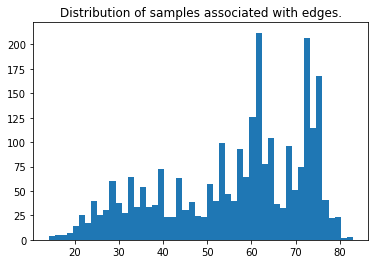

In [10]:
# first check if the network already exists and try loading it
network_with_samples_file =  out_dir+basename + ".direction="+direction+",p_val="+str(p_val)+",q="+str(q)+",min_ns="+str(min_n_samples)+".network.txt"

if not force and os.path.exists(network_with_samples_file):
    from method import print_network_stats, load_network
    network = load_network(network_with_samples_file, verbose = verbose)
    print_network_stats(network)
else:
    from partial_RRHO import precompute_RRHO_thresholds,  expression_profiles2nodes, assign_patients2edges
    from method import save_network
    # assign expression vectors on nodes 
    network = expression_profiles2nodes(network, exprs, direction)

    # define step for RRHO
    fixed_step = int(max(1,0.01*exprs.shape[1])) # 5-10-20 ~15
    if verbose:
        print("Fixed step for RRHO selected:", fixed_step, file =sys.stdout)
        
    rrho_thresholds = precompute_RRHO_thresholds(exprs, fixed_step = fixed_step,significance_thr=p_val)

    #  assign patients on edges
    network = assign_patients2edges(network,rrho_thresholds, min_SNR=min_SNR,min_n_samples=min_n_samples,
                                       fixed_step=fixed_step,verbose=verbose)
     
    
    # save the network with patients on edges 
    save_network(network, network_with_samples_file, verbose = verbose)
    
if plot_all:
    from partial_RRHO import plot_edge2sample_dist
    plot_outfile= out_dir + basename +suffix+".n_samples_on_edges.svg"
    plot_edge2sample_dist(network,plot_outfile)

# Step 2. Sample module memberships

In [11]:
from method import set_initial_conditions, sampling, get_consensus_modules

In [12]:
# simplifying probability calculations
max_log_float = np.log(np.finfo(np.float64).max)
n_exp_orders = 7 # ~1000 times 
p0 = N*np.log(0.5)+np.log(beta_K)
match_score = np.log((alpha*0.5+1)/(alpha))
mismatch_score = np.log((alpha*0.5+0)/alpha)
bK_1 = math.log(1+beta_K)

In [13]:
# Set initial model state
[moduleSizes, edge2Patients, nOnesPerPatientInModules, edge2Module, moduleOneFreqs, network] = set_initial_conditions(network, p0, match_score, mismatch_score, bK_1,N,alpha = alpha, beta_K = beta_K,verbose = verbose)

# Sampling
edge2Module_history, n_final_steps, n_skipping_edges, P_diffs = sampling(network,edge2Module, edge2Patients,
                                                                         nOnesPerPatientInModules, moduleSizes, moduleOneFreqs,
                                                                         p0, match_score, mismatch_score, bK_1, 
                                                                         alpha = alpha, beta_K = beta_K, 
                                                                         max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                                                                         n_points_fit = 10, tol = 0.1,
                                                                         n_steps_for_convergence = n_steps_for_convergence,
                                                                         edge_ordering = "shuffle", verbose=verbose)


Compute initial conditions ...
time:	Initial state created in 1.1 s.
Start sampling ...
	step  1 	% edges not changed 0.093 	runtime: 10.0 s
	step  2 	% edges not changed 0.746 	runtime: 2.7 s
	step  3 	% edges not changed 0.924 	runtime: 0.9 s
	step  4 	% edges not changed 0.957 	runtime: 0.7 s
	step  5 	% edges not changed 0.966 	runtime: 0.5 s
	step  6 	% edges not changed 0.965 	runtime: 0.4 s
	step  7 	% edges not changed 0.966 	runtime: 0.4 s
	step  8 	% edges not changed 0.971 	runtime: 0.4 s
	step  9 	% edges not changed 0.966 	runtime: 0.4 s
	step  10 	% edges not changed 0.975 	runtime: 0.4 s
	step  11 	% edges not changed 0.975 	runtime: 0.4 s
	step  12 	% edges not changed 0.979 	runtime: 0.3 s
	step  13 	% edges not changed 0.976 	runtime: 0.4 s
	step  14 	% edges not changed 0.98 	runtime: 0.4 s
	step  15 	% edges not changed 0.977 	runtime: 0.4 s
	step  16 	% edges not changed 0.976 	runtime: 0.4 s
	step  17 	% edges not changed 0.979 	runtime: 0.4 s
	step  18 	% edges n

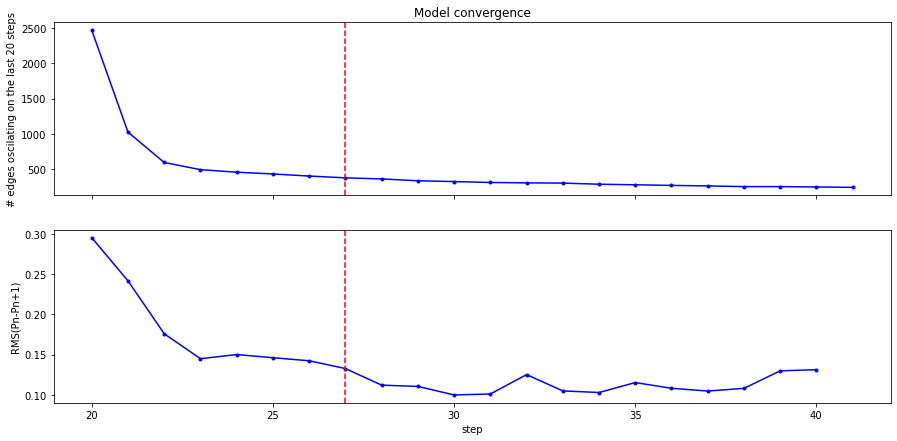

In [14]:
if plot_all:
    from method import plot_convergence
    plot_outfile = out_dir + basename +suffix+",ns_max=" + str(max_n_steps)+ ",ns_avg=" + str(n_steps_averaged) + ",ns_c="+str(n_steps_for_convergence) + ".convergence.svg"
    plot_convergence(n_skipping_edges, P_diffs,len(edge2Module_history)-n_final_steps,
                     n_steps_averaged, outfile=plot_outfile)


In [15]:
# take the last (n_points_fit+n_steps_for_convergence) steps
edge2Module_history = edge2Module_history[-n_final_steps:]

# get consensus edge-to-module membership
consensus_edge2module, network, edge2Patients, nOnesPerPatientInModules, moduleSizes, moduleOneFreqs = get_consensus_modules(edge2Module_history, network,
                                                                                                                             edge2Patients, edge2Module, nOnesPerPatientInModules,moduleSizes,
                                                                                                                             moduleOneFreqs, p0,match_score,mismatch_score, bK_1,
                                                                                                                             alpha=alpha,beta_K=beta_K)

	edge: 1354 counts: [7 5 3] 
	labels: 1392,2194,2307
	edge: 1553 counts: [3 5 7] 
	labels: 549,1553,1999
	edge: 1997 counts: [6 6 3] 
	labels: 610,948,1481
	edge: 2574 counts: [1 4 3 4 3] 
	labels: 885,1136,1831,1839,2574
55 edges changed their module membership after taking consensus.
Empty modules: 2350 
Non-empty modules: 299


# 3) Define biclusters and merge modules

In [16]:
from method import genesets2biclusters, merge_biclusters, write_bic_table

# Identify optimal patient sets for each module: split patients into two sets in a subspace of each module
# Filter out bad biclusters with too few genes or samples, or with low SNR
filtered_bics = genesets2biclusters(network,exprs_np, exprs_data,moduleSizes,consensus_edge2module,
                        min_SNR = min_SNR,direction=direction,min_n_samples=min_n_samples,
                        verbose = verbose)

time:	Identified optimal sample sets for 2649 modules in 4.79 s.
	Empty modules: 20
	Modules with just 1 edge: 20
	Modules with not enough or too many samples: 40
	Modules not passed avg. |SNR| threshold: 92
Passed modules with >= 2 edges and >= 10 samples: 147


In [17]:
# Merge remaining biclusters 
merged_bics = merge_biclusters(filtered_bics, exprs_np, exprs_data,
                               min_n_samples=min_n_samples,min_SNR=min_SNR,verbose = True, report_merging = False)

	Merge biclusters 12:6x100 (0.91,UP) and 214:52x100  (0.78,UP) --> 0.78 SNR and 55x100
	Merge biclusters 12:55x100 (0.78,UP) and 492:14x100  (0.99,UP) --> 0.77 SNR and 57x100
	Merge biclusters 12:57x100 (0.77,UP) and 504:7x100  (1.0,UP) --> 0.77 SNR and 57x100
	Merge biclusters 12:57x100 (0.77,UP) and 538:7x100  (0.92,UP) --> 0.77 SNR and 58x100
	Merge biclusters 12:58x100 (0.77,UP) and 1424:10x100  (0.84,UP) --> 0.77 SNR and 65x100
	Merge biclusters 12:65x100 (0.77,UP) and 1777:8x100  (0.96,UP) --> 0.77 SNR and 68x100
	Merge biclusters 12:68x100 (0.77,UP) and 1938:6x100  (0.96,UP) --> 0.77 SNR and 70x100
	Merge biclusters 71:25x100 (0.91,UP) and 510:10x100  (0.99,UP) --> 0.92 SNR and 32x100
	Merge biclusters 71:32x100 (0.92,UP) and 1147:11x100  (0.98,UP) --> 0.91 SNR and 35x100
	Merge biclusters 71:35x100 (0.91,UP) and 1960:11x100  (0.81,UP) --> 0.88 SNR and 44x100
	Merge biclusters 295:31x100 (0.9,UP) and 611:34x100  (0.95,UP) --> 0.9 SNR and 51x100
	Merge biclusters 295:51x100 (0.9,

	Merge biclusters 784:76x100 (0.89,UP) and 2556:3x101  (1.06,UP) --> 0.89 SNR and 77x100
	Merge biclusters 758:50x100 (0.95,UP) and 1168:4x101  (1.01,UP) --> 0.95 SNR and 54x100
	Merge biclusters 1420:48x100 (0.84,UP) and 2424:4x99  (0.9,UP) --> 0.82 SNR and 49x100
	Merge biclusters 442:84x100 (0.8,UP) and 2439:6x99  (0.82,UP) --> 0.79 SNR and 86x100
	Merge biclusters 442:86x100 (0.79,UP) and 468:3x104  (1.04,UP) --> 0.79 SNR and 86x100
	Merge biclusters 758:54x100 (0.95,UP) and 2575:3x102  (1.02,UP) --> 0.96 SNR and 55x100
	Merge biclusters 295:91x100 (0.8,UP) and 1807:5x102  (0.85,UP) --> 0.8 SNR and 92x100
	Merge biclusters 834:61x100 (0.87,UP) and 1545:5x100  (0.79,UP) --> 0.86 SNR and 66x100
	Merge biclusters 1682:49x100 (0.91,UP) and 2066:5x100  (0.85,UP) --> 0.89 SNR and 50x100
	Merge biclusters 1005:67x100 (0.94,UP) and 2243:3x93  (1.08,UP) --> 0.95 SNR and 69x100
	Merge biclusters 381:71x100 (0.92,UP) and 1428:5x100  (0.95,UP) --> 0.91 SNR and 72x100
	Merge biclusters 381:72x1

In [18]:
i =0
print()
for bic in merged_bics:
    bic["id"] = i
    i+=1
    bic["genes"] = { ints2g_names[x] for x in bic["genes"] }
    bic["samples"] = { ints2s_names[x] for x in bic["samples"] }
    print("\t".join(map(str,[bic["id"],bic["n_genes"],bic["n_samples"],
                                     bic["avgSNR"],bic["direction"]])), file = sys.stdout)


0	70	100	0.7713605546787887	UP
1	75	100	0.8142690718738621	UP
2	87	100	0.7950651221274454	UP
3	92	100	0.7973615647750502	UP
4	75	100	0.9019216856821155	UP
5	86	100	0.8458129104382749	UP
6	60	100	0.9400543383954806	UP
7	68	100	0.855610825832983	UP
8	73	100	0.9349616349208684	UP
9	49	100	0.8243993525655079	UP
10	58	100	0.8728102330137943	UP


In [19]:
result_file_name = out_dir+basename+suffix
write_bic_table(merged_bics,
                result_file_name+".biclusters.tsv")


print("Total runtime:",round(time.time()-start_time,2),file = sys.stdout)

Total runtime: 81.93


In [20]:
print(result_file_name)

/home/olya/SFU/Breast_cancer/DESMOND_py3/tmp.alpha=1.0,beta_K=1.0,direction=UP,p_val=0.01,q=0.5


# All steps in one function

In [21]:
from method import prepare_input_data
from partial_RRHO import relabel_exprs_and_network, define_SNR_threshold
from method import set_initial_conditions, sampling, get_consensus_modules
from method import genesets2biclusters, merge_biclusters, write_bic_table

Will save output files to: ./tmp.alpha=1.0,beta_K=1.0,direction=UP,p_val=0.01,q=0.5
Input:
 	expressions: 2000 genes x 200 samples; 
	network: 2000 genes, 14863 edges in 1 connected components:
Processed Input:
 	expressions: 2000 genes x 200 samples; 
	network: 2000 genes  14863 edges in 1 connected components:
time:	Inputs read in 0.22 s.
Mininal number of samples in a module: 10
Using pre-computed SNR threshold:	0.767 (q=0.5)
Loading annotated network from  ./tmp.direction=UP,p_val=0.01,q=0.5,min_ns=10.network.txt ...
time: load_network() runtime 0.35 s
Undirected graph with 2 connected components; with 1051 nodes and 2649 edges;
Connected component 1 : 1048 nodes and 2647 edges
Connected component 2 : 3 nodes and 2 edges
Compute initial conditions ...
time:	Initial state created in 1.0 s.
Start sampling ...
	step  1 	% edges not changed 0.089 	runtime: 7.2 s
	step  2 	% edges not changed 0.772 	runtime: 1.6 s
	step  3 	% edges not changed 0.918 	runtime: 1.1 s
	step  4 	% edges not

	Merge biclusters 1238:56x100 (0.94,UP) and 1946:12x100  (0.94,UP) --> 0.94 SNR and 61x100
	Merge biclusters 1238:61x100 (0.94,UP) and 1952:11x100  (0.93,UP) --> 0.93 SNR and 64x100
	Merge biclusters 1238:64x100 (0.93,UP) and 2200:12x100  (0.85,UP) --> 0.91 SNR and 68x100
	Merge biclusters 1238:68x100 (0.91,UP) and 2202:5x100  (1.08,UP) --> 0.91 SNR and 69x100
	Merge biclusters 1298:10x100 (1.07,UP) and 2403:16x100  (1.01,UP) --> 1.04 SNR and 26x100
	Merge biclusters 1298:26x100 (1.04,UP) and 2417:20x100  (0.87,UP) --> 0.97 SNR and 44x100
	Merge biclusters 1298:44x100 (0.97,UP) and 2581:7x100  (0.84,UP) --> 0.95 SNR and 50x100
	Merge biclusters 1489:14x100 (0.93,UP) and 1990:9x100  (0.81,UP) --> 0.87 SNR and 22x100
	Merge biclusters 1489:22x100 (0.87,UP) and 2301:9x100  (0.93,UP) --> 0.88 SNR and 30x100
	Merge biclusters 2371:11x100 (0.83,UP) and 2393:10x100  (1.08,UP) --> 0.95 SNR and 21x100
	Merge biclusters 2371:21x100 (0.95,UP) and 2449:13x100  (0.91,UP) --> 0.93 SNR and 34x100
	Me

	Merge biclusters 43:83x100 (0.86,UP) and 2253:4x103  (0.86,UP) --> 0.86 SNR and 85x100
	Merge biclusters 660:94x100 (0.77,UP) and 2183:3x105  (1.05,UP) --> 0.77 SNR and 94x100
	Merge biclusters 25:92x100 (0.8,UP) and 671:3x101  (1.14,UP) --> 0.8 SNR and 93x100
	Merge biclusters 225:76x100 (0.85,UP) and 959:3x101  (0.86,UP) --> 0.84 SNR and 77x100
	Merge biclusters 25:93x100 (0.8,UP) and 734:4x103  (0.83,UP) --> 0.8 SNR and 93x100
	Merge biclusters 25:93x100 (0.8,UP) and 793:3x98  (0.87,UP) --> 0.79 SNR and 94x100
	Merge biclusters 123:76x100 (0.79,UP) and 391:4x99  (0.8,UP) --> 0.78 SNR and 78x100
	Merge biclusters 123:78x100 (0.78,UP) and 1570:3x100  (0.87,UP) --> 0.78 SNR and 79x100
	Merge biclusters 25:94x100 (0.79,UP) and 71:3x101  (0.83,UP) --> 0.79 SNR and 95x100
	Merge biclusters 73:65x100 (0.91,UP) and 1792:3x102  (0.88,UP) --> 0.91 SNR and 66x100
time:	Merging (144 cycles, 140 successful merges) fininshed in 6.72 s.
Modules remaining after merging: 11

0	95	100	0.787791803001

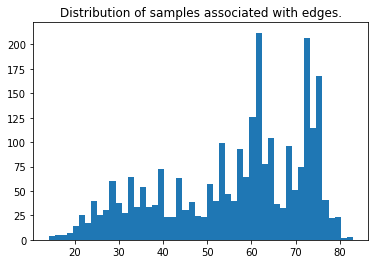

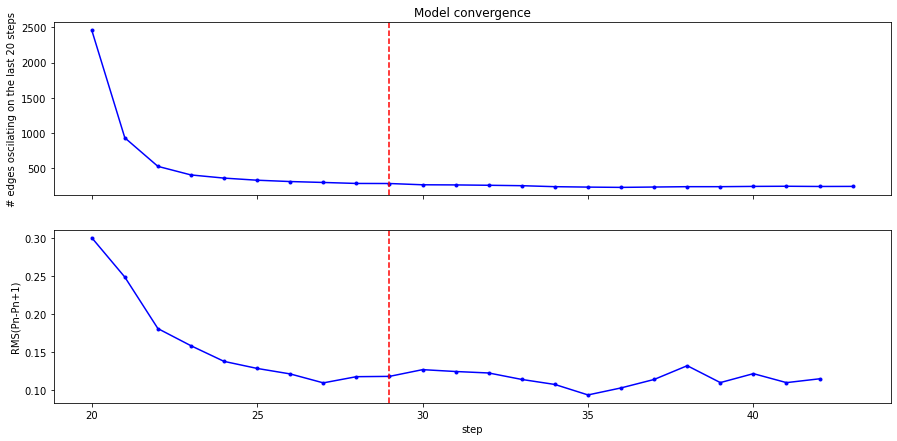

In [22]:
def run_DESMOND(exprs_file,network_file,
                direction="UP", min_n_samples = -1,
                p_val = 0.01,alpha=1.0 ,beta_K=1.0, q=0.5,
                out_dir = "./",basename = False,
                max_n_steps= 200, n_steps_averaged = 20, n_steps_for_convergence = 5,
                force = False, plot_all=True, report_merging = False, verbose = True):
    
    start_time = time.time()
    
    if basename:
        basename = basename
    else: 
        [date_h,mins] = str(datetime.datetime.today()).split(":")[:2]
        [date, hs] = date_h.split()
        basename = "results_"+hs+":"+mins+"_"+date 
    
    suffix  = ".alpha="+str(alpha)+",beta_K="+str(beta_K)+",direction="+direction+",p_val="+str(p_val)+",q="+str(q)
    if verbose:
        print("Will save output files to:",out_dir + basename + suffix, file = sys.stdout)

    ### 1. Assigning samples to edges ###
    # read inputs
    exprs, network = prepare_input_data(exprs_file, network_file, verbose = verbose, min_n_nodes = 3)
    
    # define minimal number of patients in a module
    if min_n_samples == -1:
        min_n_samples = int(max(10,0.05*exprs.shape[1])) # set to max(10, 5% of the cohort) 
    if verbose:
        print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)

    # change gene and sample names to ints
    exprs,network,ints2g_names,ints2s_names = relabel_exprs_and_network(exprs,network)
    exprs_np = exprs.values
    exprs_sums = exprs_np.sum(axis=1)
    exprs_sq_sums = np.square(exprs_np).sum(axis=1)
    N = exprs.shape[1]
    exprs_data = N, exprs_sums, exprs_sq_sums
    
    # read min_SNR from file or determine it from avg.SNR distributions among 1000 random edges
    snr_file = out_dir+basename +",q="+str(q) +".SNR_threshold.txt"
    if not force and os.path.exists(snr_file) and os.path.getsize(snr_file) > 0:
        f = open(snr_file,"r")
        min_SNR = f.readlines()[0]
        f.close()
        try:
            min_SNR = float(min_SNR)
            if verbose:
                print("Using pre-computed SNR threshold:\t%s (q=%s)"%(min_SNR,q),file=sys.stdout)
        except:
            min_SNR = define_SNR_threshold(exprs_np, exprs_data,network,q,snr_file,
                                       min_n_samples=min_n_samples,verbose=verbose)
    else:
        min_SNR = define_SNR_threshold(exprs_np, exprs_data,network,q,snr_file,
                                       min_n_samples=min_n_samples,verbose=verbose)

    # first check if the network already exists and try loading it
    network_with_samples_file =  out_dir+basename + ".direction="+direction+",p_val="+str(p_val)+",q="+str(q)+",min_ns="+str(min_n_samples)+".network.txt"

    if not force and os.path.exists(network_with_samples_file):
        from method import print_network_stats, load_network
        network = load_network(network_with_samples_file, verbose = verbose)
        print_network_stats(network)
    else:
        from partial_RRHO import precompute_RRHO_thresholds,  expression_profiles2nodes, assign_patients2edges
        from method import save_network
        # assign expression vectors on nodes 
        network = expression_profiles2nodes(network, exprs, direction)

        # define step for RRHO
        fixed_step = int(max(1,0.01*exprs.shape[1])) # 5-10-20 ~15
        if verbose:
            print("Fixed step for RRHO selected:", fixed_step, file =sys.stdout)

        rrho_thresholds = precompute_RRHO_thresholds(exprs, fixed_step = fixed_step,significance_thr=p_val)

        #  assign patients on edges
        network = assign_patients2edges(network,rrho_thresholds, min_SNR=min_SNR,min_n_samples=min_n_samples,
                                           fixed_step=fixed_step,verbose=verbose)


        # save the network with patients on edges 
        save_network(network, network_with_samples_file, verbose = verbose)

    if plot_all:
        from partial_RRHO import plot_edge2sample_dist
        plot_outfile= out_dir + basename +suffix+".n_samples_on_edges.svg"
        plot_edge2sample_dist(network,plot_outfile)
        
    ### 2. Edge clustering ###
    
    # simplifying probability calculations
    max_log_float = np.log(np.finfo(np.float64).max)
    n_exp_orders = 7 # ~1000 times 
    p0 = N*np.log(0.5)+np.log(beta_K)
    match_score = np.log((alpha*0.5+1)/(alpha))
    mismatch_score = np.log((alpha*0.5+0)/alpha)
    bK_1 = math.log(1+beta_K)
    
    # set initial model state
    [moduleSizes, edge2Patients, nOnesPerPatientInModules, edge2Module, moduleOneFreqs, network] = set_initial_conditions(network, p0, match_score, mismatch_score, bK_1,N,
                                                                                                                          alpha = alpha, beta_K = beta_K,verbose = verbose)

    # sampling
    edge2Module_history, n_final_steps, n_skipping_edges, P_diffs = sampling(network,edge2Module, edge2Patients,
                                                                             nOnesPerPatientInModules, moduleSizes, moduleOneFreqs,
                                                                             p0, match_score, mismatch_score, bK_1, 
                                                                             alpha = alpha, beta_K = beta_K, 
                                                                             max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                                                                             n_points_fit = 10, tol = 0.1,
                                                                             n_steps_for_convergence = n_steps_for_convergence,
                                                                             edge_ordering = "shuffle", verbose=verbose)
    if plot_all:
        from method import plot_convergence
        plot_outfile = out_dir + basename +suffix+",ns_max=" + str(max_n_steps)+ ",ns_avg=" + str(n_steps_averaged) + ",ns_c="+str(n_steps_for_convergence) + ".convergence.svg"
        plot_convergence(n_skipping_edges, P_diffs,len(edge2Module_history)-n_final_steps,
                         n_steps_averaged, outfile=plot_outfile)

    # take the last (n_points_fit+n_steps_for_convergence) steps
    edge2Module_history = edge2Module_history[-n_final_steps:]

    # get consensus edge-to-module membership
    consensus_edge2module, network, edge2Patients, nOnesPerPatientInModules, moduleSizes, moduleOneFreqs = get_consensus_modules(edge2Module_history, network,
                                                                                                                                 edge2Patients, edge2Module, nOnesPerPatientInModules,moduleSizes,
                                                                                                                                 moduleOneFreqs, p0,match_score,mismatch_score, bK_1,
                                                                                                                                 alpha=alpha,beta_K=beta_K,verbose= verbose)
    #### 3. Define biclusters and merge modules  ####
    
    # identify optimal patient sets for each module: split patients into two sets in a subspace of each module
    # filter out bad biclusters with too few genes or samples, or with low SNR
    filtered_bics = genesets2biclusters(network,exprs_np, exprs_data,moduleSizes,consensus_edge2module,
                            min_SNR = min_SNR,direction=direction,min_n_samples=min_n_samples,
                            verbose = verbose)
    
    # merge remaining biclusters 
    merged_bics = merge_biclusters(filtered_bics, exprs_np, exprs_data,
                               min_n_samples=min_n_samples,min_SNR=min_SNR,
                                   verbose = verbose, report_merging = report_merging)
    
    # print info on merged biclusters
    if verbose:
        i =0
        print()
        for bic in merged_bics:
            bic["id"] = i
            i+=1
            bic["genes"] = { ints2g_names[x] for x in bic["genes"] }
            bic["samples"] = { ints2s_names[x] for x in bic["samples"] }
            print("\t".join(map(str,[bic["id"],bic["n_genes"],bic["n_samples"],
                                             bic["avgSNR"],bic["direction"]])), file = sys.stdout)
        
    # save results 
    result_file_name = out_dir+basename+suffix
    write_bic_table(merged_bics,
                    result_file_name+".biclusters.tsv")
    if verbose:
        print("Total runtime:",round(time.time()-start_time,2),file = sys.stdout)
    return merged_bics

merged_bics = run_DESMOND(exprs_file,network_file,direction="UP",basename = "tmp")